## Parallelization of cluster and validation: Kmeans, Majority Vote on half moons

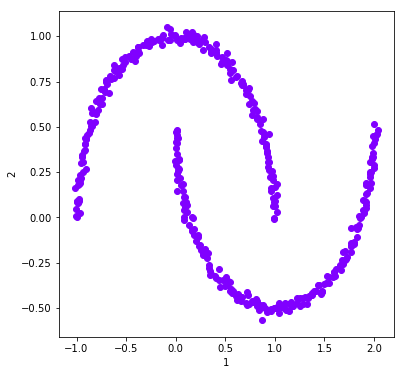

In [1]:
# Reproduce Ana Fred's Majority voting solution to stabilizing KMeans clustering using OpenEnsembles
# This example demonstrates how an ensemble of kmeans solutions, which are constrained to finding spheroids
# can identify contigous structres
import pandas as pd 
import random
import matplotlib.pyplot as plt
from sklearn import datasets
import openensembles as oe


n_samples = 400
X, y = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=0.02, random_state=None)
df = pd.DataFrame(X)

dataObj = oe.data(df, [1,2])
dataObj.plot_data('parent')



### Example of using OpenEnsembles to create and visualize a single solution

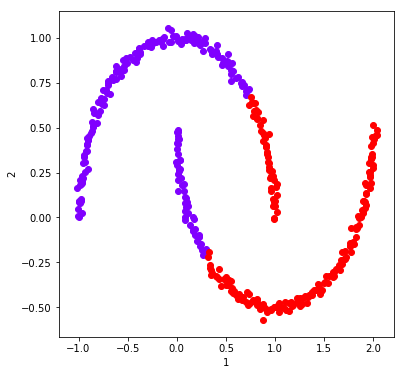

In [2]:
#Plot a single solution 
# default Scikit-learn settings have built in some determinism using Ana Fred's principals, so we have to override those

c = oe.cluster(dataObj) 
K = 2
name = 'kmeans'
c.cluster('parent', 'kmeans', name, K, init = 'random', n_init = 1)
dataObj.plot_data('parent', class_labels=c.labels['kmeans'])


### Create an ensemble of kmeans, plot convergence towards solution with parallelization

In [3]:
# Build towards a majority voting that finds the two continuous partitions
c = oe.cluster(dataObj) 
K = 10 
numIterations = 40
c_MV_arr = []
modulo = 1 #if you want to calculate majority vote only ever other or few solutions, increase this number
sil_arr = []
det_arr = []
num_clusters = []

# Wrapper function for running an iteration
def run_cluster_iteration(c, i):
    name = 'kmeans_' + str(i)
    c.cluster('parent', 'kmeans', name, K, init = 'random', n_init = 1)
    return c

def run_val_iteration(c, i):
    #take a slice of the ensemble of size i
    names = list(c.labels.keys())
    cSlice = c.slice(names[0:i])
    
    x = cSlice.finish_majority_vote(threshold=0.5)
    v = oe.validation(dataObj, x)

    #A compactness metric
    validation_name = 'silhouette'
    v.calculate(validation_name, 'majority_vote', 'parent')
    name = validation_name+'_parent_majority_vote'
    sil_val = v.validation[name]

    #A metric for connectedness
    validation_name = 'det_ratio'
    v.calculate(validation_name, 'majority_vote', 'parent')
    name = validation_name+'_parent_majority_vote'
    det_val = v.validation[name]

    return (x, len(x.clusterNumbers['majority_vote']), sil_val, det_val)

    
# Use python's multiprocessing module to run in parallel
from multiprocessing import Pool
N_THREADS = 4
pool = Pool(processes=N_THREADS)

# Run clustering in parallel
cluster_apply_results = [pool.apply_async(run_cluster_iteration, (c, i)) for i in range(1, numIterations)]
cluster_results = [x.get() for x in cluster_apply_results]

# Merge the results
#First, establish a non-empty parent cluster to merge remainder of iterations with (which are an array of cluster objects)
c = cluster_results[0]
cluster_td = c.merge(cluster_results[1:])

# Run validation in parallel -- calculate majority vote for every possible slice of c 
val_apply_results = [pool.apply_async(run_val_iteration, (c, i)) for i in range(1, numIterations) if not i % modulo]
val_results = [x.get() for x in val_apply_results]
#val_results = [run_val_iteration(c, i) for i in range(1, numIterations) if not i % modulo]

# Merge the results
for r in val_results:
    c_MV_arr.append(r[0])
    num_clusters.append(r[1])
    sil_arr.append(r[2])
    det_arr.append(r[3])


/Users/knaegle/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/knaegle/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/knaegle/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/knaegle/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/knaegle/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/knaegle/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.

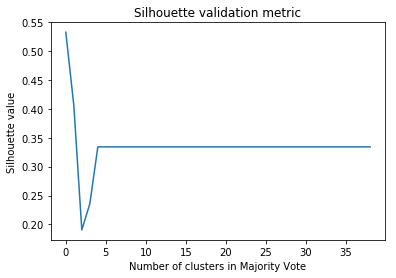

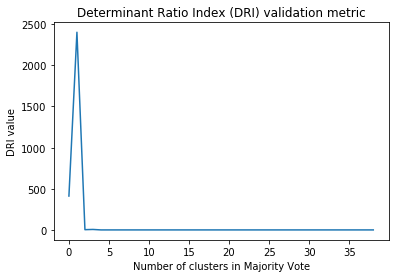

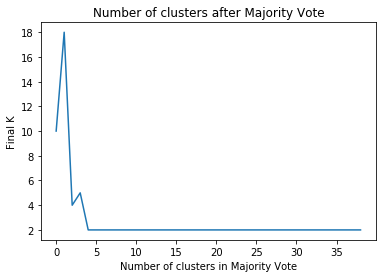

In [6]:
#Compactness
plt.plot(sil_arr)
plt.title('Silhouette validation metric')
plt.xlabel('Number of clusters in Majority Vote')
plt.ylabel('Silhouette value')
plt.show()

#Connectedness
plt.plot(det_arr)
plt.title('Determinant Ratio Index (DRI) validation metric')
plt.xlabel('Number of clusters in Majority Vote')
plt.ylabel('DRI value')
plt.show()

#Convergence towards final K
plt.plot(num_clusters)
plt.xlabel('Number of clusters in Majority Vote')
plt.ylabel('Final K')
plt.title('Number of clusters after Majority Vote')
plt.show()

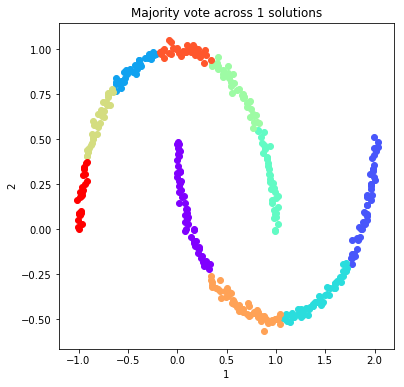

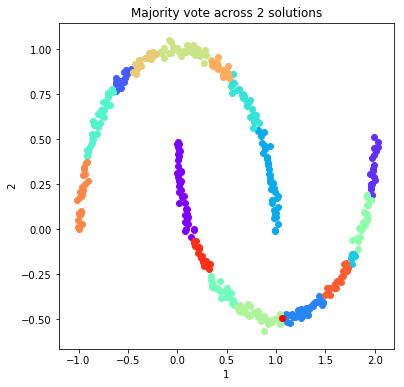

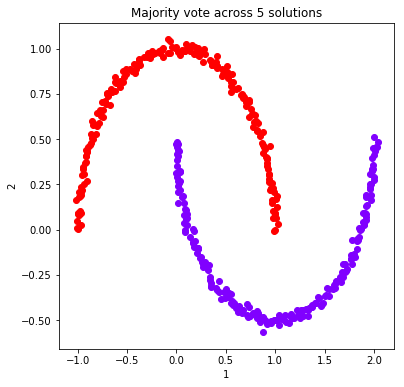

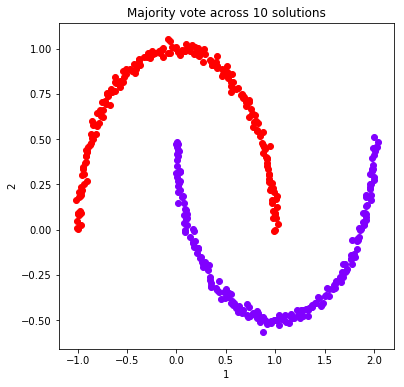

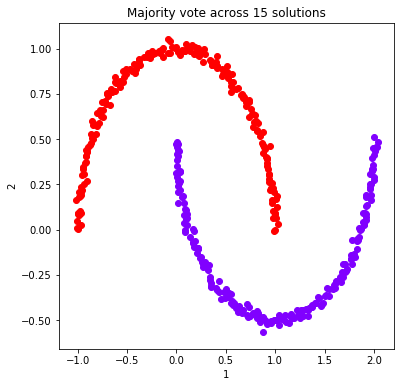

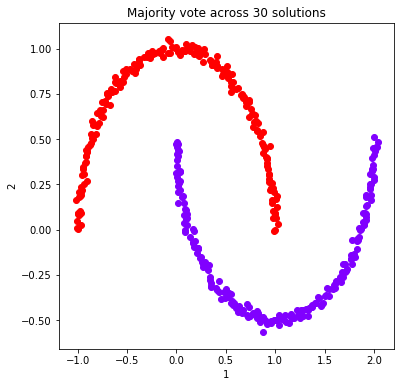

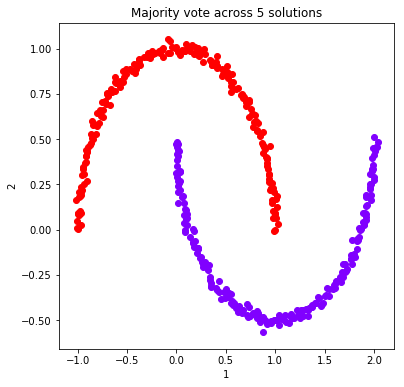

In [7]:
# Plot some span of solutoins, including the one that minimizes connectedness 
import operator
idx, value = min(enumerate(det_arr), key=operator.itemgetter(1)) #Where the connectedness metric minimized

toPlot = [0, 1, 4, 9, 14, 29, idx]
for ind in toPlot:

    fig = dataObj.plot_data('parent', class_labels=c_MV_arr[ind].labels['majority_vote'])
    plt.title('Majority vote across %d solutions'%(ind+1))
    plt.show()
